## Week 7 Video Notebook -- Gradient Boosting Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the California Housing Dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [3]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an empty dictionary to store results
results = {}

### Gradient Boosting Regression: Best Practices for Hyperparameter Tuning

There is a large number of different hyperparameters. Grid search can help find the optimal model for your goals, but some general guidelines can be established. 

### General Tuning Guidelines
1. Start Simply:
   - Use the default settings and validate the model's performance on your dataset.
   - Gradually tune one parameter at a time.
   - If your dataset is very large, take a random sample to tune your parameters at first, then check it on the whole dataset for a few critical choices. 

2. Focus on Learning Rate and Number of Estimators:
   - These two hyperparameters have the most significant impact on performance.
   - Use grid or random search to find an optimal combination.

3. Use a Validation Set:
   - Always validate performance on a separate validation set to avoid overfitting.
   
4. When parameters can be integers or floats (e.g., `min_samples_split`, `min_samples_leaf`), try using the float (percentage of the dataset size $n$) rather than int (number of datapoints), especially for large datasets. 

5. Balance Bias and Variance:
   - Lower `max_depth`, smaller `subsample`, and smaller `min_samples_split` reduce variance.
   - Larger `n_estimators`, lower `learning_rate`, and higher `max_features` increase variance but reduce bias.
   
6. Always remember that a held-out test set is your best measure of the ability of your model to generalize! Think of it as a **final exam** after which no more learning can take place!  If you tune your parameters based on the test score, then you are making it into a second validation set, and it no longer can be used as a proxy for "unseen data" (since it has been seen by you!). 


### Detailed Tuning Guidelines

Here are some details (copied from the `sklearn` documentation) and best practices; these are listed in approximately their importance in the tuning process (think about them in this order). 

- **`n_estimators`** (int), range (1, $\infty$],default=100.  The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. 

    - Best Practices:
       - Increase from default (e.g., `500` or more) when using a smaller `learning_rate`.
       - Watch for diminishing returns as the number increases; too large can lead to computational inefficiency.
    - Pro Tip: Use early stopping to automatically halt training when performance on a validation set stops improving (see next section). 
   
--- 

- **`learning_rate`** (float), range (0.0, $\infty$], default=0.1. Shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. 

   - Best Practices:
     - Use a lower value (e.g., `0.01` or `0.001`) for better generalization, paired with a higher `n_estimators`. This is particularly use in noisy datasets. 
     - Trade-off: Lower values require more boosting stages (higher `n_estimators`), increasing computation time.
   - Pro Tip: Use grid search or random search to balance `learning_rate` and `n_estimators` efficiently.

---


- **`max_depth`** (int or None), range (1,$\infty$], default=3: Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. The best value depends on the interaction of the input variables. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 

   - Best Practices:
     - Start with the default (`3`) for tabular datasets.
     - Shallow trees (e.g., max_depth=2 or 3) often work well with a higher `n_estimators` and smaller `learning_rate`, balancing bias and variance.
     - Increase for complex interactions (e.g., `5` or `7`) or decrease (e.g., `2`) for very noisy data.
   - Pro Tip: Avoid setting this too high, or to None, as it can lead to overfitting and increased computation time.

--- 

- **`loss`**:  Loss function to be optimized. 

    - ‘squared_error’: L2 loss     (default)
    - ‘absolute_error’: L1 loss 
    - 'huber': Combination of L1 and L2

    - Best Practices:
         - Use `'absolute_error'` if your data contains significant outliers, but note that it may be slower.
         - Consider `'huber'` for datasets with a mix of outliers and well-behaved data, as it combines L1 and L2 losses.
    - When to Experiment:
         - Only if your task involves unusual data distributions or if outliers significantly affect model performance.
         
---

- **`subsample`** (float), range (0.0, 1.0], default=1.0.  The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. This parameter interacts significantly with  `n_estimators` and `learning_rate`. It also fits well with the Bias-Variance-Tradeoff: 
- Smaller values increase bias and reduce variance, which may help with noisy datasets; however, the model can underfit because each tree trains on too little data to learn meaningful pattern;
- Larger values decrease bias and increase variance, and can overfit, especially on noisy datasets, as the trees may become too closely aligned to the training data. 

   - Best Practices:
     - Start with the default (`1.0`) for full-boosting.
     - Decrease for noisy data, keeping an eye on the other parameters mentioned above. 

   - Pro Tip: Values in the range `[0.6, 0.8]` often perform well in practice.

         
---

- **`max_features`** {None, ‘sqrt’, ‘log2’, int, float}, default=None. The number of features to consider when looking for the best split:

      - int or float:  Either number of features or percentage of all features. 

      - “sqrt”: max_features = sqrt(n_features).

      - “log2”: max_features = log2(n_features).

      - None:   max_features = n_features.
        
   - Best Practices:
     - Choosing max_features < n_features leads to a reduction of variance and an increase in bias.
     - For large datasets or high-dimensional data, set to `'sqrt'` or `'log2'` to reduce computational cost and variance.
     - For datasets with correlated features, smaller max_features values ('sqrt' or 0.3) can improve performance by increasing randomness in splits.
     - For smaller datasets, consider setting this to `None` for maximum performance.
   - Pro Tip: Smaller values (e.g., `'sqrt'`) improve diversity among trees and can reduce overfitting.

---

- **`min_samples_split`** (int or float), default=2:  The minimum number of samples required to split an internal node:

   - Best Practices:
     - For large or imbalanced datasets, use values between 0.01 and 0.05, depending on the noise in the data.
     
---

- **`min_samples_leaf`** (int or float), default=1:  The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

    - Best Practices:
        - For small dataset, default integer should be fine, but could increase (e.g., 5, 10) to smooth predictions and reduce overfitting, especially for regression tasks.
        - For large, noisy, or imbalanced datasets, or those with extreme outliers, use floats between 0.01 and 0.10 to avoid overfitting. 


In [4]:
### Gradient Boosting Regressor ###
print("\nRunning Gradient Boosting Regressor...")
boosting_model = GradientBoostingRegressor(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Shrinkage factor
    max_depth=3,  # Depth of individual trees
    random_state=42
)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
mse_boosting = mean_squared_error(y_test, y_pred_boosting)
r2_boosting = r2_score(y_test, y_pred_boosting)
results["Boosting"] = {"MSE": mse_boosting, "R^2": r2_boosting}
print(f"Gradient Boosting - MSE: {mse_boosting:.3f}, R^2: {r2_boosting:.3f}")


Running Gradient Boosting Regressor...
Gradient Boosting - MSE: 0.294, R^2: 0.776


In [5]:
# Plot of mean of 10 trials of MSE vs num estimators

n_trials = 10

M_gb = [None]*n_trials

nums = list(range(50,1001,50))
    
for n in range(n_trials):

    mses_gb = []

    for n_estimators in tqdm(nums):
        boosting_model = GradientBoostingRegressor(
            n_estimators=n_estimators,  # Number of boosting rounds
            learning_rate=0.1,  # Shrinkage factor
            max_depth=3,  # Depth of individual trees
    #         random_state=42
        )
        boosting_model.fit(X_train, y_train)
        y_pred_boosting = boosting_model.predict(X_test)
        mse_boosting = mean_squared_error(y_test, y_pred_boosting)
        mses_gb.append(mse_boosting)

    M_gb[n] = mses_gb
    
M_gb = np.array(M_gb)

100%|███████████████████████████████████████████| 20/20 [04:42<00:00, 14.12s/it]


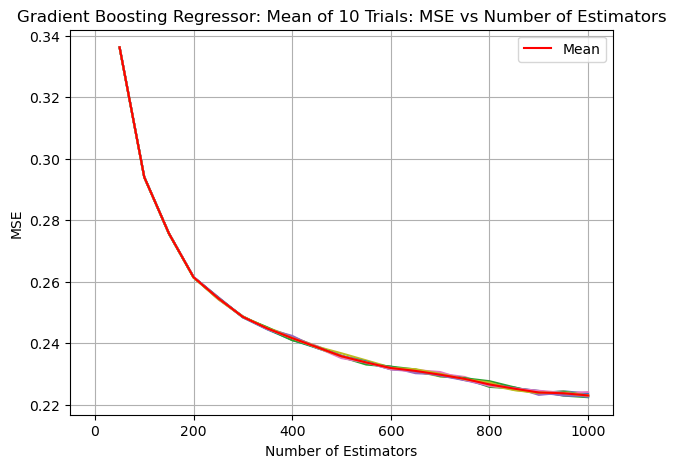

In [6]:
# Plot
plt.figure(figsize=(7, 5))

plt.title("Gradient Boosting Regressor: Mean of 10 Trials: MSE vs Number of Estimators")
for n in range(n_trials):
    plt.plot(nums, M_gb[n],0.25)
plt.plot(nums, np.mean(M_gb,axis=0),color='red',label='Mean')
plt.xlabel("Number of Estimators")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

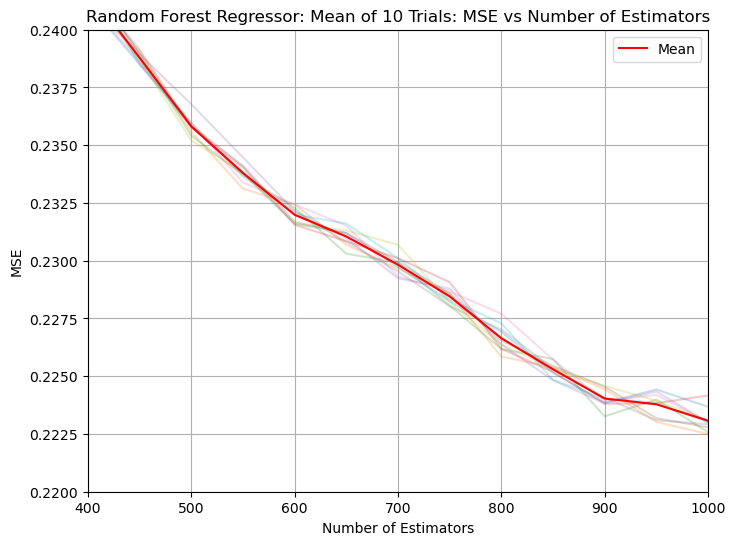

In [7]:
# Plot
plt.figure(figsize=(8, 6))

plt.title("Random Forest Regressor: Mean of 10 Trials: MSE vs Number of Estimators")
for n in range(n_trials):
    plt.plot(nums, M_gb[n],alpha=0.25)
plt.plot(nums, np.mean(M_gb,axis=0),color='red',label='Mean')
plt.xlabel("Number of Estimators")
plt.ylabel("MSE")
plt.ylim(0.22,0.24)
plt.xlim(400,1000)
plt.legend()
plt.grid()
plt.show()

In [8]:
sorted([(21,3),(5,4),(18,3)])

[(5, 4), (18, 3), (21, 3)]

In [9]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

validation_results = []

def run_GB_traces(n_estimators,learning_rate_list,max_depth_list):
    
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:



            # Initialize the Gradient Boosting Regressor
            gbr = GradientBoostingRegressor(n_estimators=n_estimators, 
                                            learning_rate=learning_rate, 
                                            max_depth=max_depth, 
                                            random_state=42)

            # Fit the model to the training data
            gbr.fit(X_train, y_train)

            # Arrays to store errors at each stage
            train_errors = []
            val_errors = []

            # Iterate through each stage of predictions
            for y_pred_train, y_pred_val in zip(
                gbr.staged_predict(X_train),
                gbr.staged_predict(X_val),
            ):
                # Calculate errors for each dataset
                train_error = mean_squared_error(y_train, y_pred_train)
                val_error = mean_squared_error(y_val, y_pred_val)

                # Append errors to respective lists
                train_errors.append(train_error)
                val_errors.append(val_error)

            # Find the minimum Validation MSE and its corresponding iteration
            min_val_mse = min(val_errors)
            min_val_iter = val_errors.index(min_val_mse)
            
            validation_results.append((min_val_mse,min_val_iter,n_estimators,learning_rate,max_depth))

            # Calculate Test MSE for the iteration with minimum Validation MSE
            y_pred_test_at_min_val = list(gbr.staged_predict(X_test))[min_val_iter]
            test_mse_at_min_val = mean_squared_error(y_test, y_pred_test_at_min_val)

            # Calculate Test MSE for the final model
            final_test_mse = mean_squared_error(y_test, gbr.predict(X_test))

            # Print the results
            print('n_estimators:', n_estimators, '   learning_rate:', learning_rate, '   max_depth:', max_depth)
            print(f"Minimum Validation MSE: {min_val_mse:.4f} at iteration {min_val_iter}")
            print(f"Test MSE at Minimum Validation MSE: {test_mse_at_min_val:.4f}")
            print(f"Final Test MSE: {final_test_mse:.4f}")

            # Plot the errors
            plt.figure(figsize=(10, 6))
            plt.plot(train_errors, label="Training Error",color='blue')
            plt.plot(val_errors, label="Validation Error",color='green')
            plt.plot([min_val_iter,min_val_iter], [0,0.5], color="red", linestyle='--', alpha=0.4,label="Min Validation MSE")
            plt.scatter([min_val_iter], [test_mse_at_min_val], color="red", marker='x', label="Test MSE at Min Validation")
            plt.scatter([n_estimators-1], [final_test_mse], color='red', marker='d', label='Final Test MSE')
            plt.xlabel("Boosting Iterations")
            plt.ylabel("Mean Squared Error")
            plt.ylim(0, 0.5)
            plt.title("Training and Validation Errors Across Boosting Iterations")
            plt.legend()
            plt.grid()
            plt.show()
            
    tmp = sorted(validation_results)
    print("Best three results:",tmp[:3])

# run_GB_traces(2000,[0.5, 0.1, 0.05],[2,3,5,7,9])

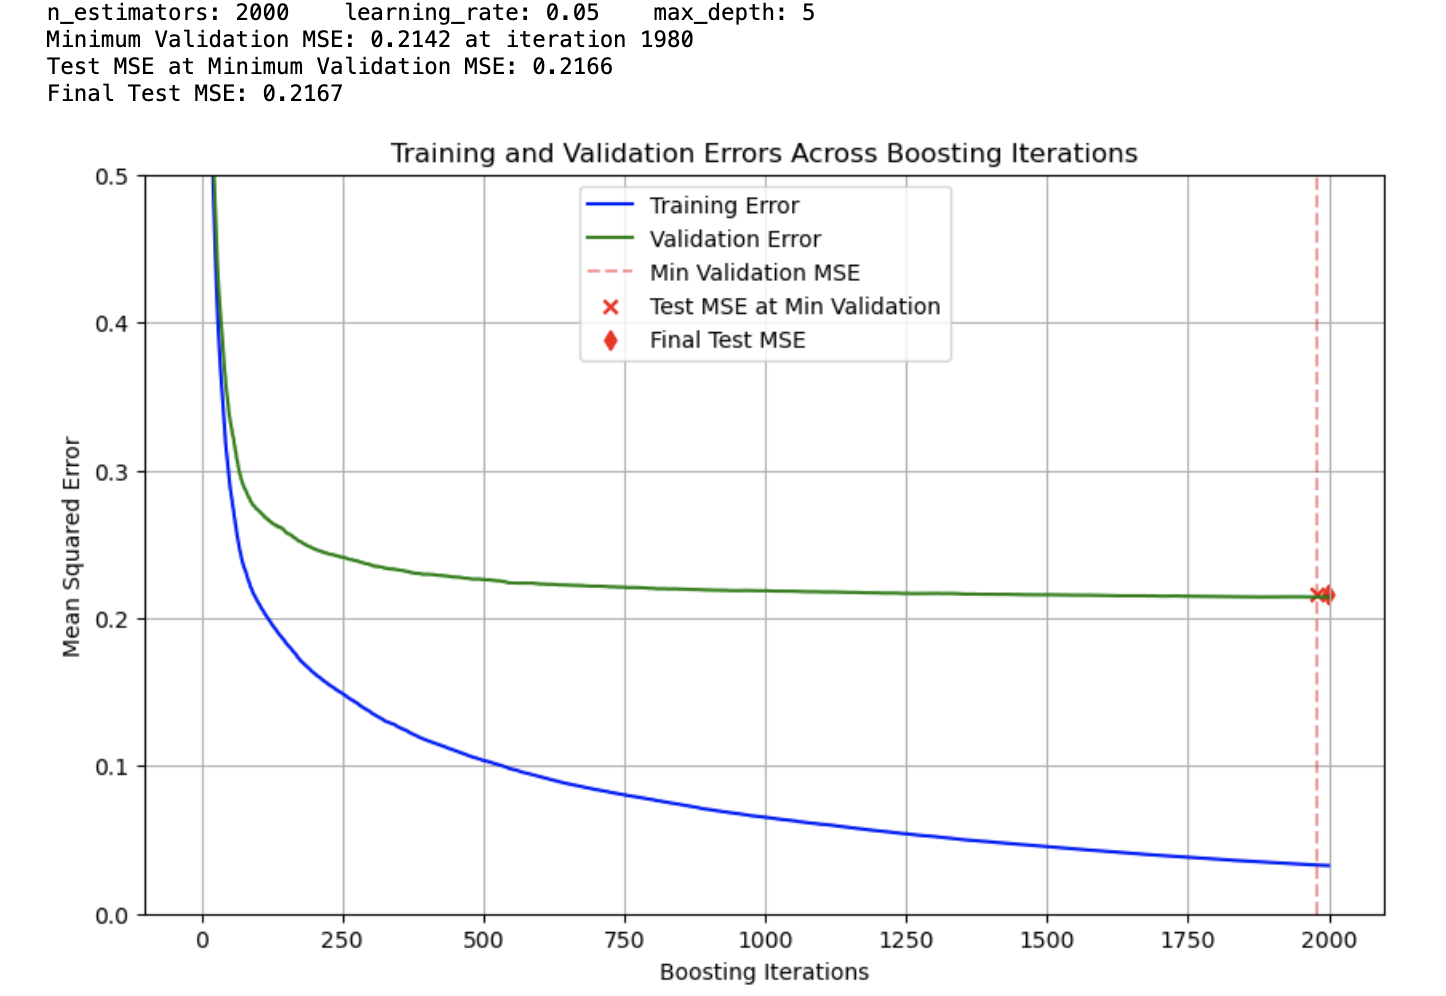


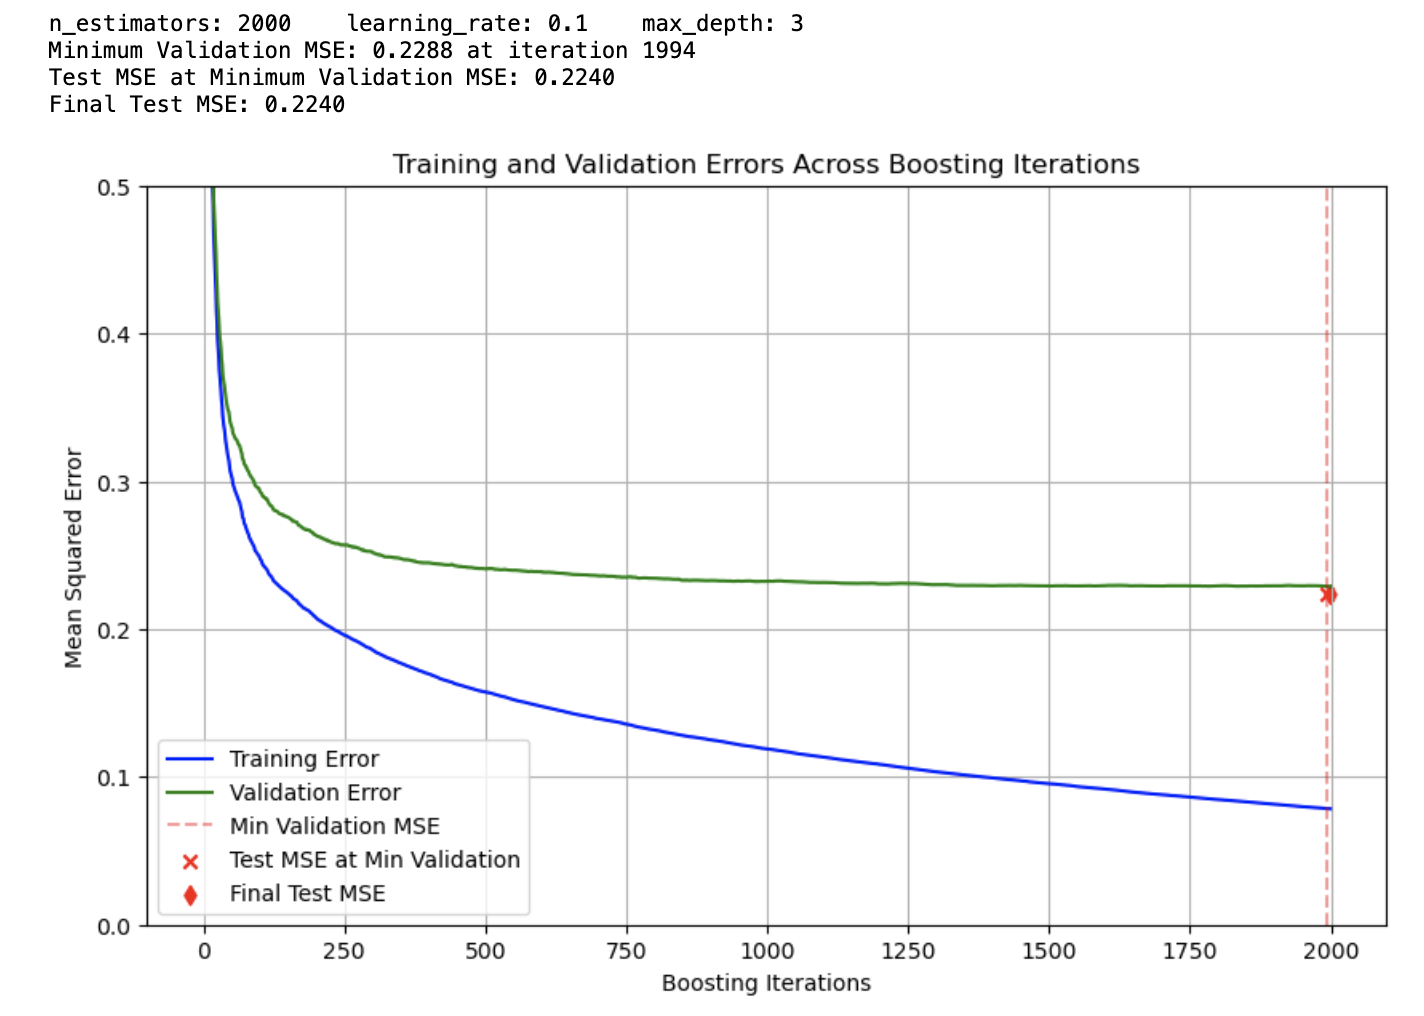

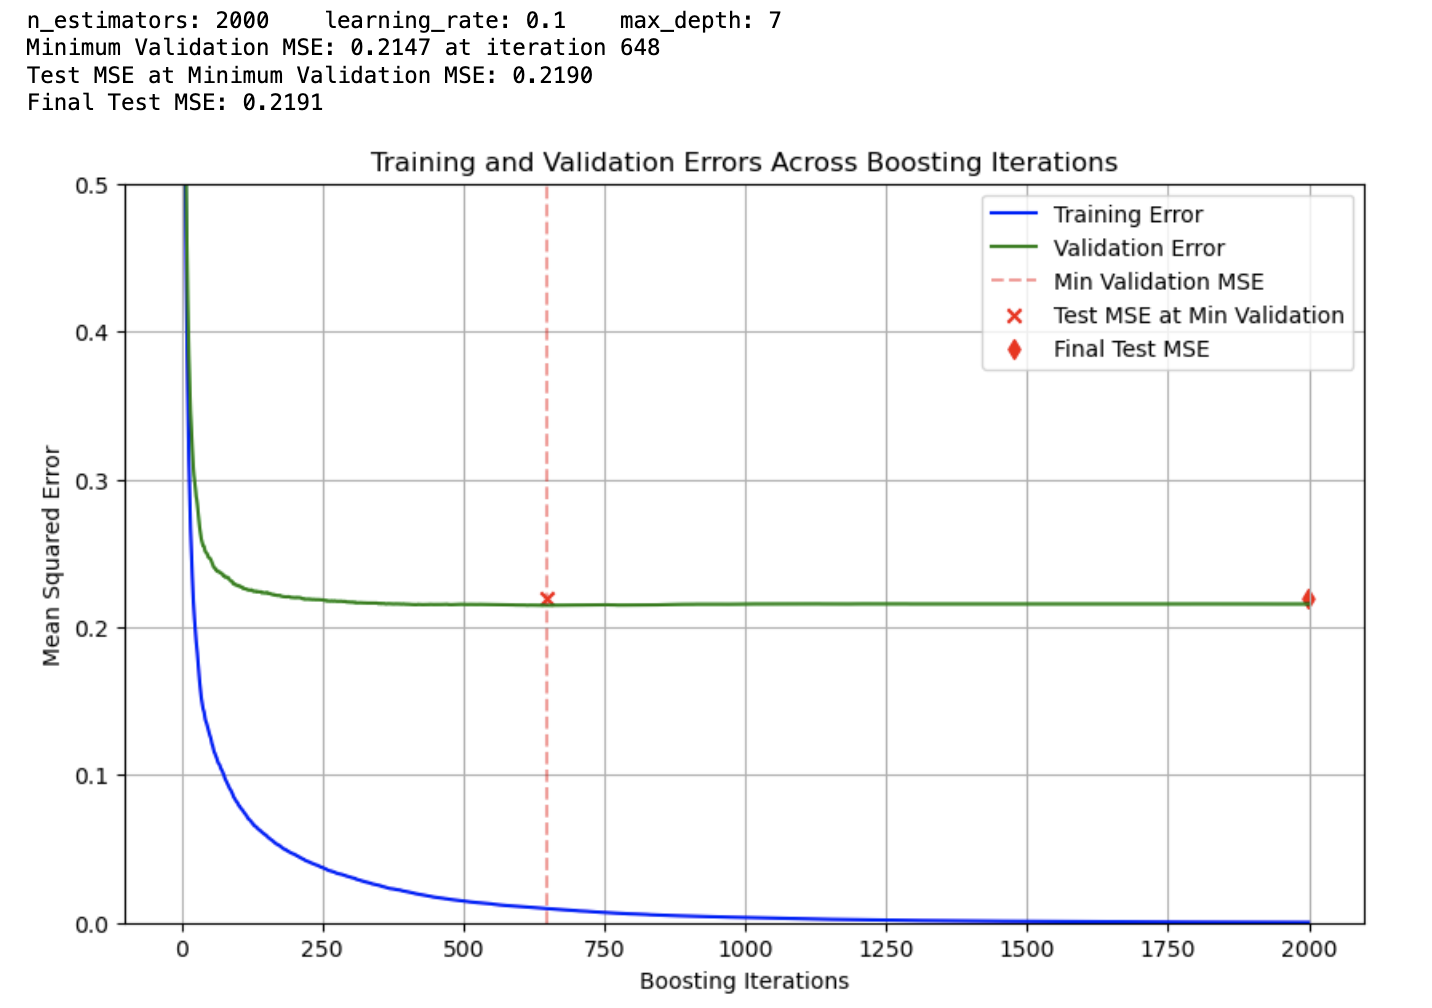

n_estimators: 5000    learning_rate: 0.1    max_depth: 7
Minimum Validation MSE: 0.2147 at iteration 648
Test MSE at Minimum Validation MSE: 0.2190
Final Test MSE: 0.2190


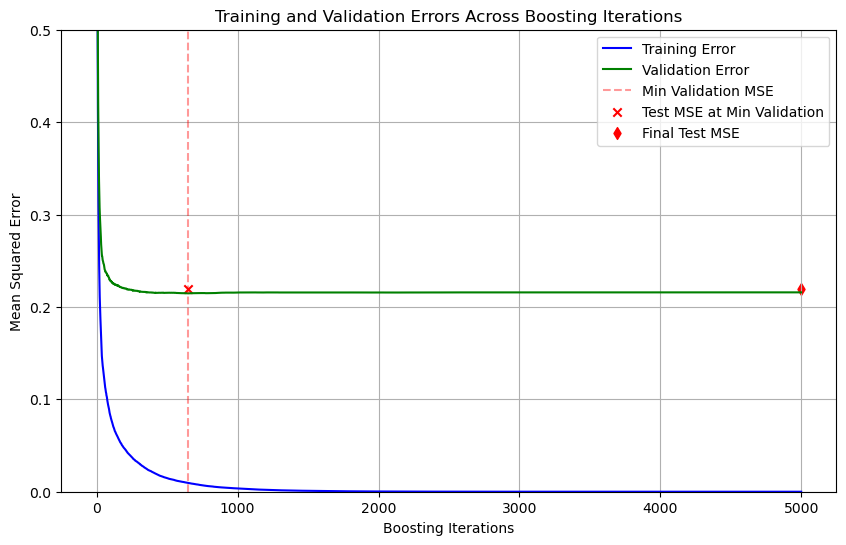

n_estimators: 5000    learning_rate: 0.1    max_depth: 8
Minimum Validation MSE: 0.2184 at iteration 628
Test MSE at Minimum Validation MSE: 0.2192
Final Test MSE: 0.2186


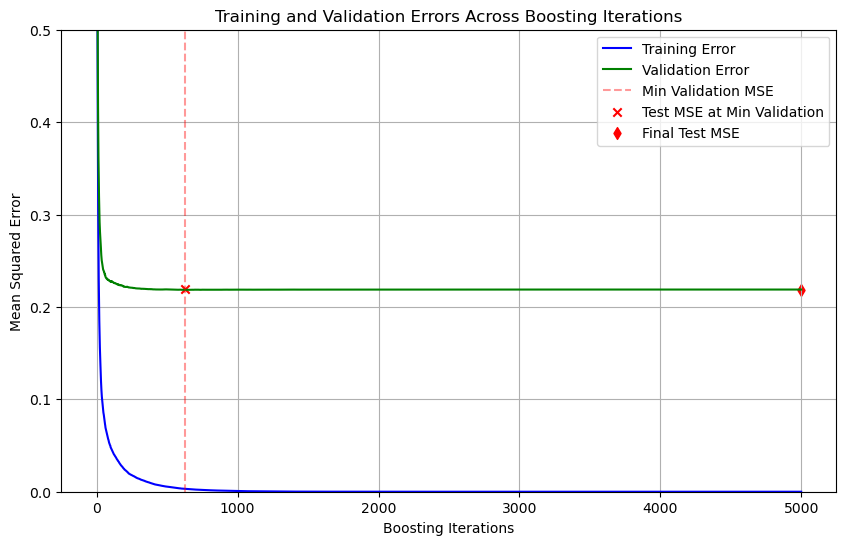

n_estimators: 5000    learning_rate: 0.1    max_depth: 9
Minimum Validation MSE: 0.2266 at iteration 1041
Test MSE at Minimum Validation MSE: 0.2299
Final Test MSE: 0.2298


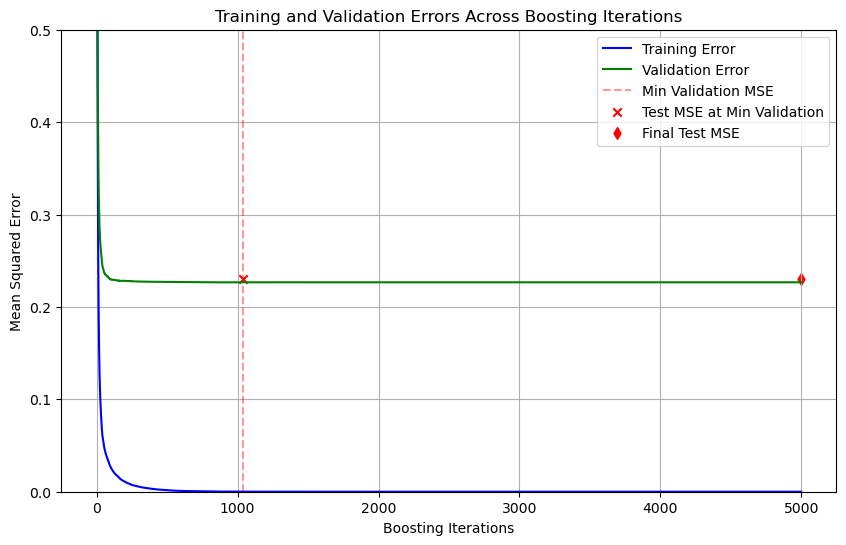

n_estimators: 5000    learning_rate: 0.1    max_depth: 10
Minimum Validation MSE: 0.2334 at iteration 381
Test MSE at Minimum Validation MSE: 0.2378
Final Test MSE: 0.2374


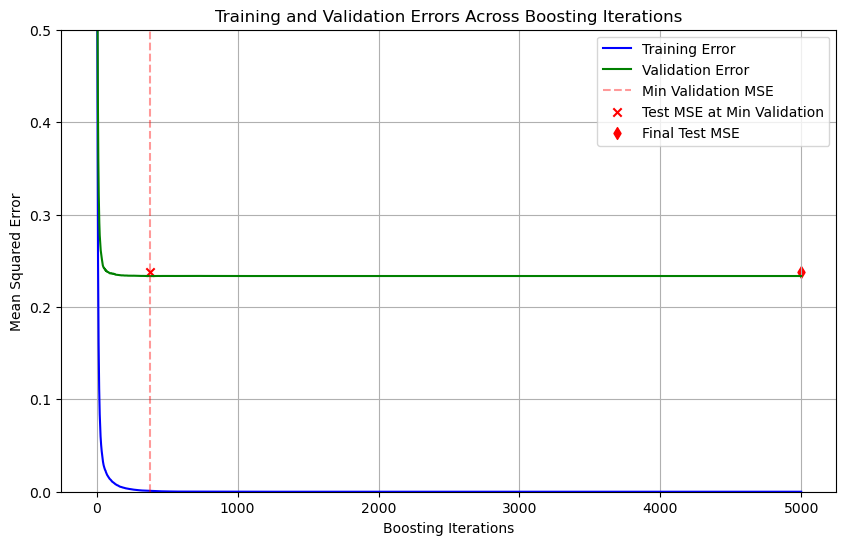

n_estimators: 5000    learning_rate: 0.05    max_depth: 7
Minimum Validation MSE: 0.2145 at iteration 2208
Test MSE at Minimum Validation MSE: 0.2133
Final Test MSE: 0.2132


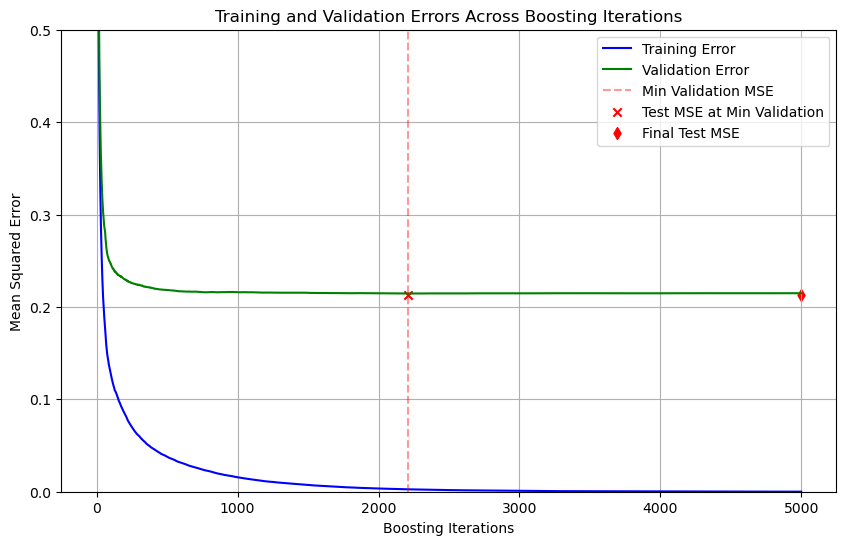

n_estimators: 5000    learning_rate: 0.05    max_depth: 8
Minimum Validation MSE: 0.2177 at iteration 4082
Test MSE at Minimum Validation MSE: 0.2179
Final Test MSE: 0.2179


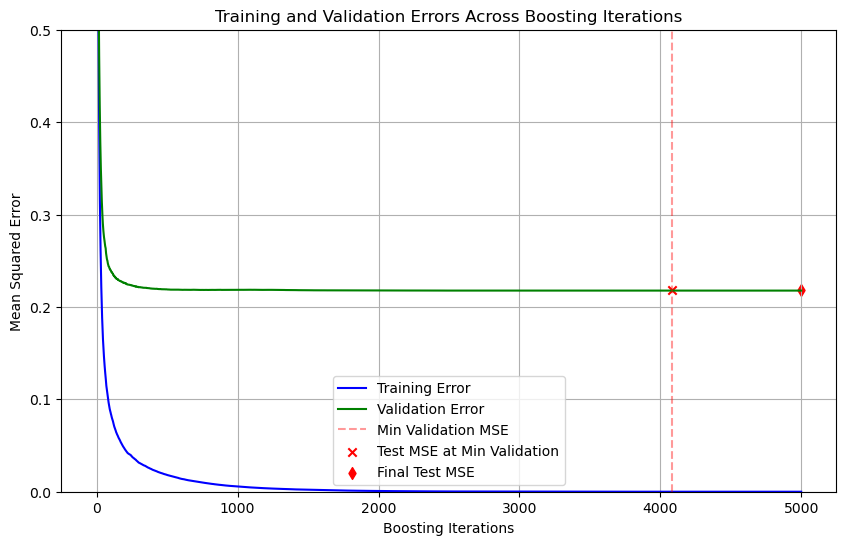

n_estimators: 5000    learning_rate: 0.05    max_depth: 9
Minimum Validation MSE: 0.2224 at iteration 1382
Test MSE at Minimum Validation MSE: 0.2256
Final Test MSE: 0.2255


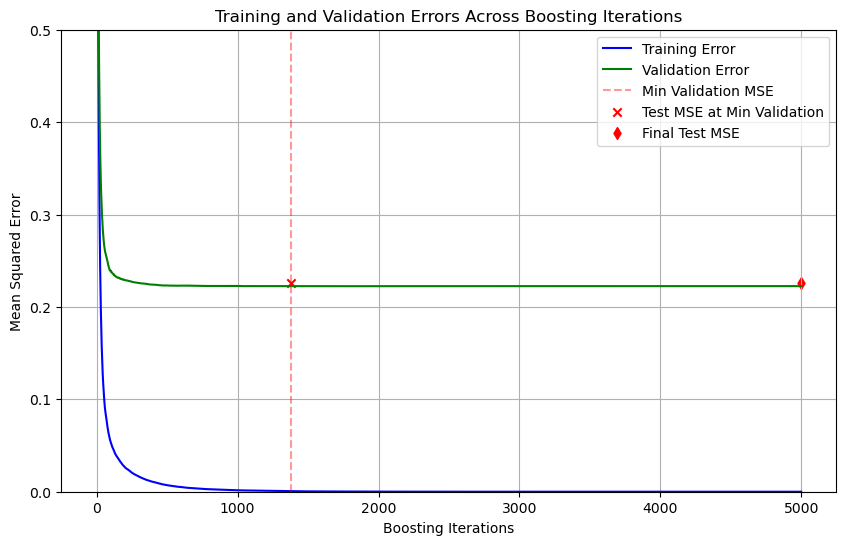

n_estimators: 5000    learning_rate: 0.05    max_depth: 10
Minimum Validation MSE: 0.2327 at iteration 1736
Test MSE at Minimum Validation MSE: 0.2355
Final Test MSE: 0.2355


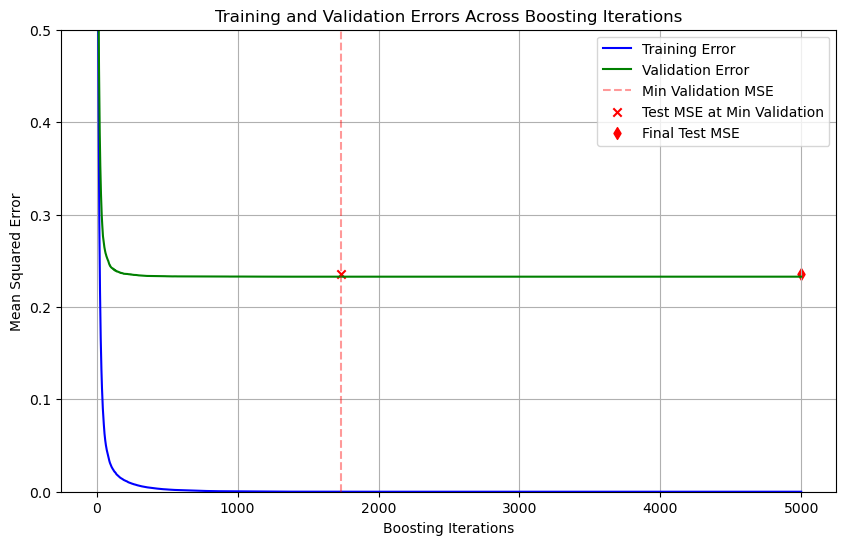

n_estimators: 5000    learning_rate: 0.01    max_depth: 7
Minimum Validation MSE: 0.2129 at iteration 4999
Test MSE at Minimum Validation MSE: 0.2139
Final Test MSE: 0.2139


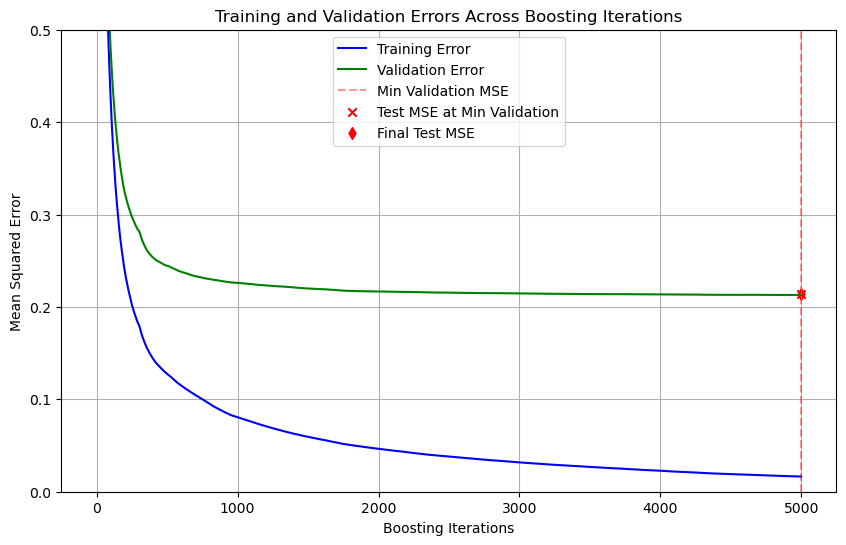

n_estimators: 5000    learning_rate: 0.01    max_depth: 8
Minimum Validation MSE: 0.2160 at iteration 4445
Test MSE at Minimum Validation MSE: 0.2158
Final Test MSE: 0.2158


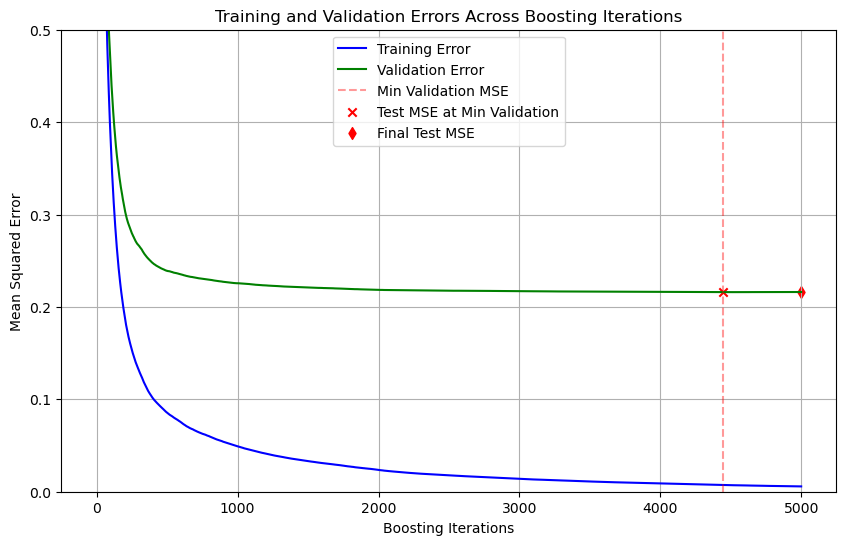

n_estimators: 5000    learning_rate: 0.01    max_depth: 9
Minimum Validation MSE: 0.2205 at iteration 4987
Test MSE at Minimum Validation MSE: 0.2218
Final Test MSE: 0.2218


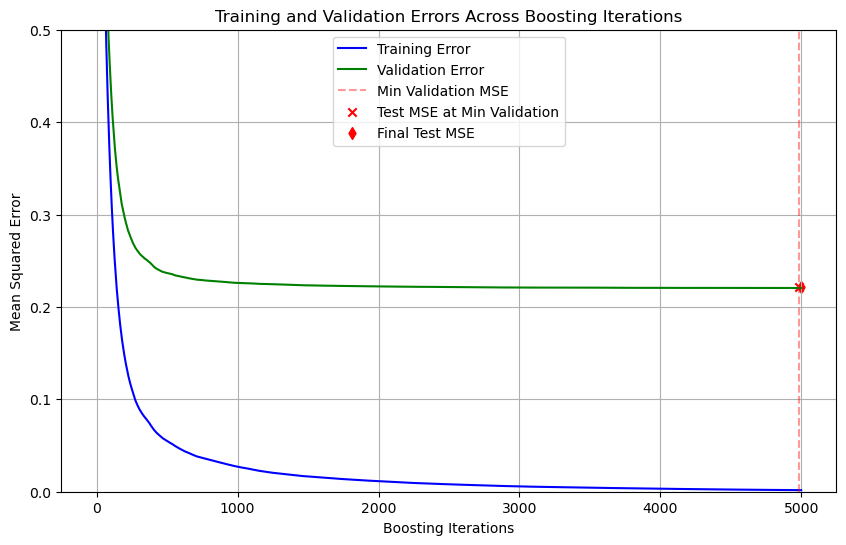

n_estimators: 5000    learning_rate: 0.01    max_depth: 10
Minimum Validation MSE: 0.2308 at iteration 4541
Test MSE at Minimum Validation MSE: 0.2352
Final Test MSE: 0.2352


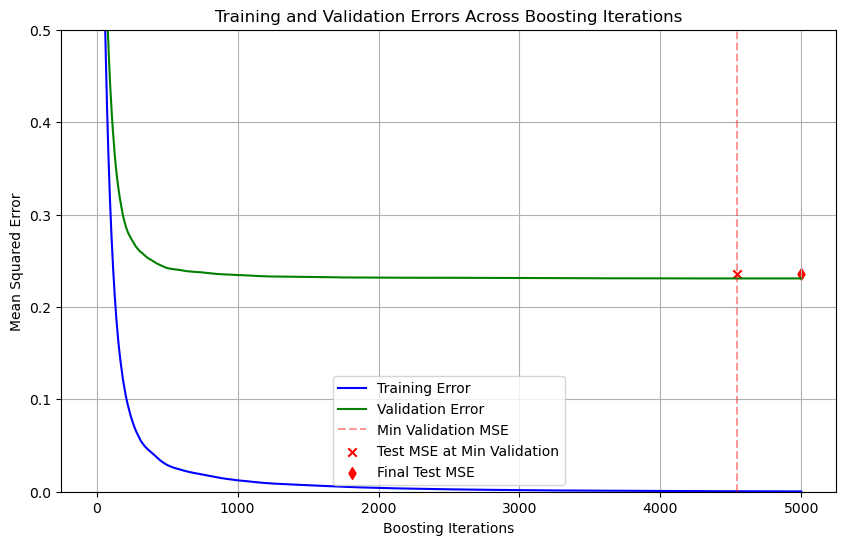

Best three results: [(0.21287373820203492, 4999, 5000, 0.01, 7), (0.2145021971111606, 2208, 5000, 0.05, 7), (0.21466899787878388, 648, 5000, 0.1, 7)]


In [10]:
run_GB_traces(5000,[0.1, 0.05, 0.01],[7,8,9,10])

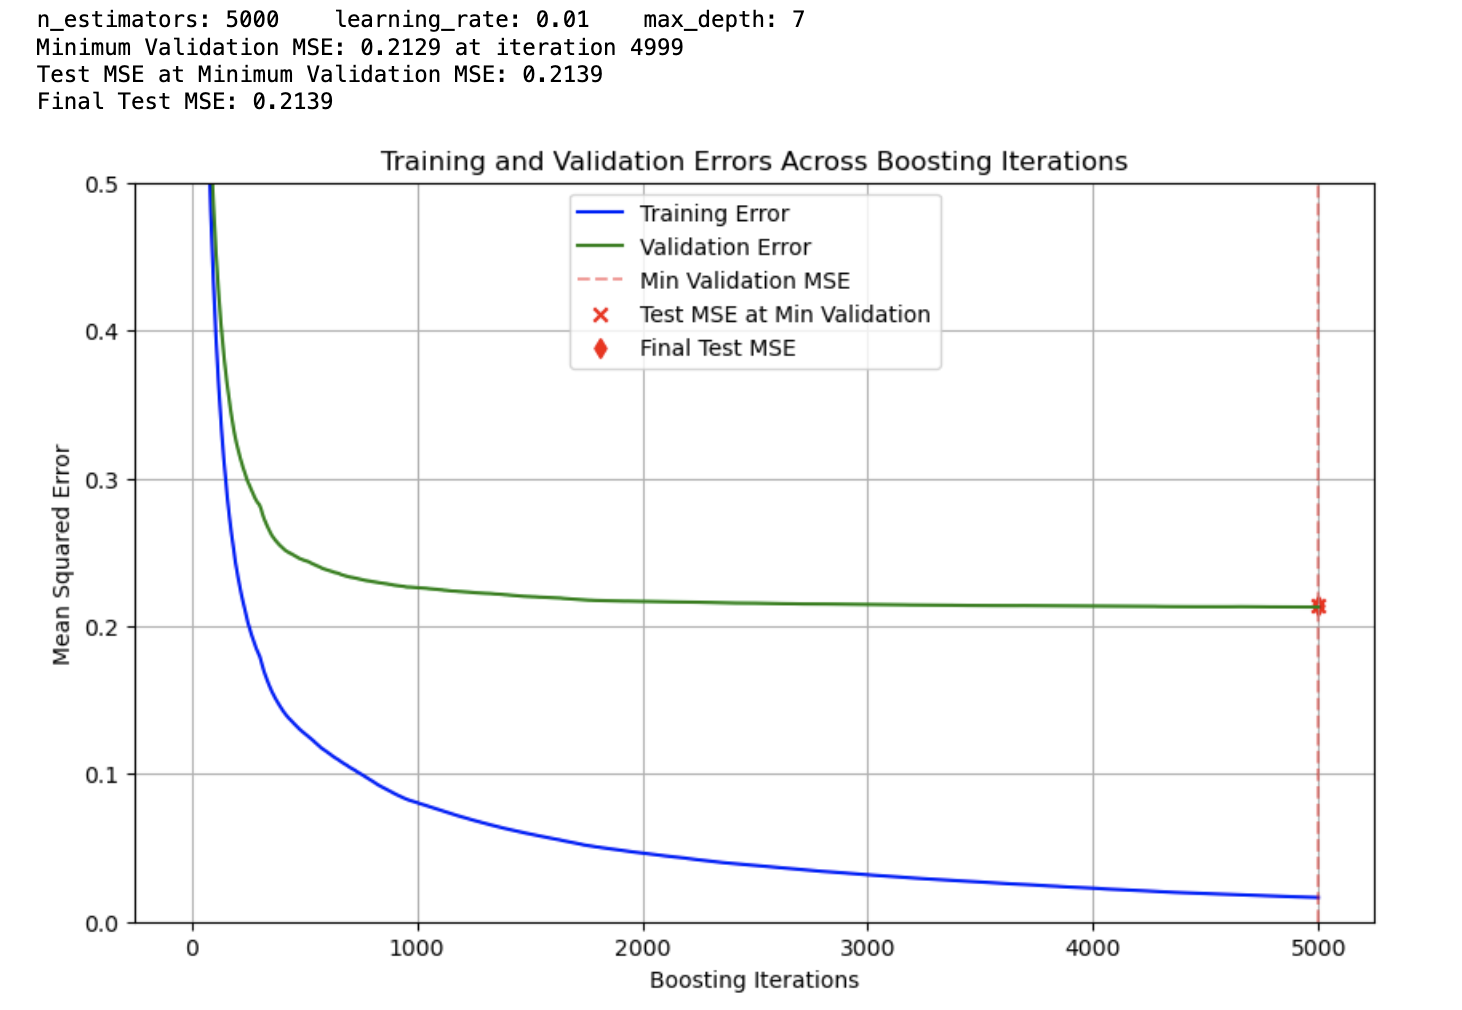

The other two are from the previous run!

n_estimators: 10000    learning_rate: 0.05    max_depth: 5
Minimum Validation MSE: 0.2137 at iteration 2381
Test MSE at Minimum Validation MSE: 0.2159
Final Test MSE: 0.2175


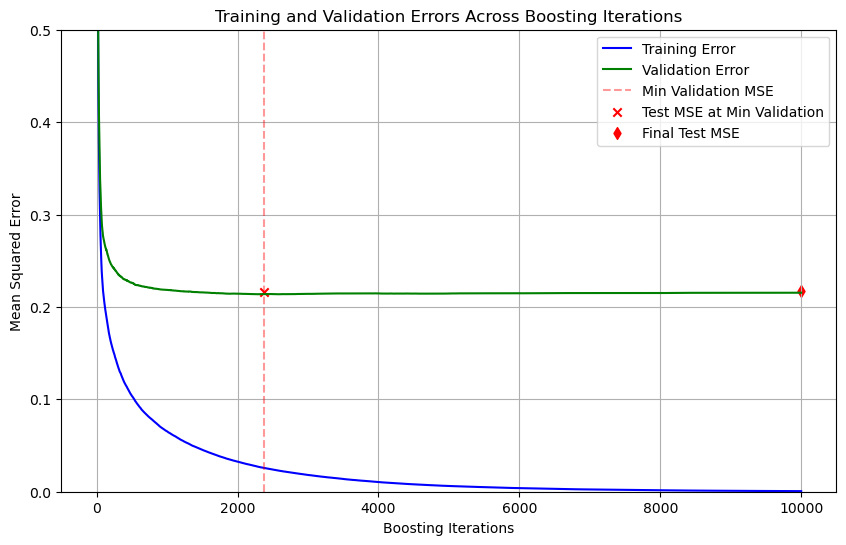

n_estimators: 10000    learning_rate: 0.05    max_depth: 6
Minimum Validation MSE: 0.2074 at iteration 4454
Test MSE at Minimum Validation MSE: 0.2100
Final Test MSE: 0.2103


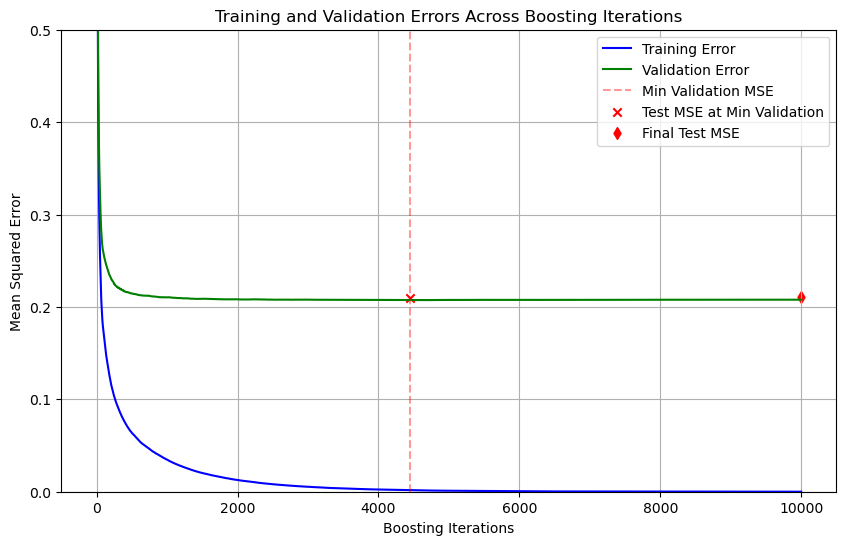

n_estimators: 10000    learning_rate: 0.05    max_depth: 7
Minimum Validation MSE: 0.2145 at iteration 2208
Test MSE at Minimum Validation MSE: 0.2133
Final Test MSE: 0.2132


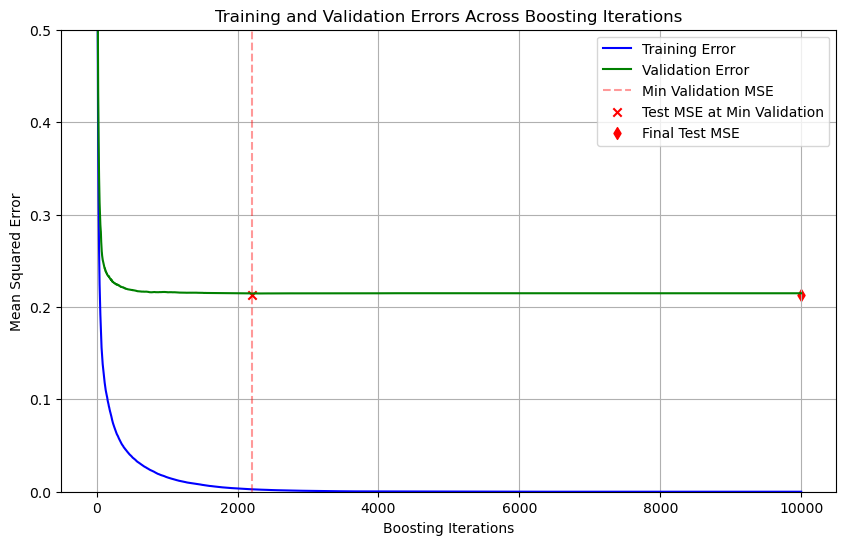

n_estimators: 10000    learning_rate: 0.05    max_depth: 8
Minimum Validation MSE: 0.2177 at iteration 4082
Test MSE at Minimum Validation MSE: 0.2179
Final Test MSE: 0.2179


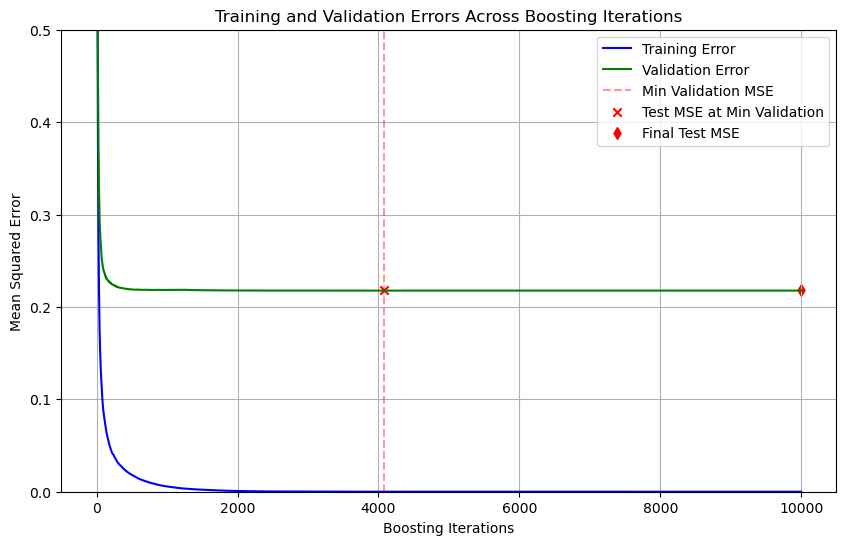

n_estimators: 10000    learning_rate: 0.01    max_depth: 5
Minimum Validation MSE: 0.2142 at iteration 9535
Test MSE at Minimum Validation MSE: 0.2148
Final Test MSE: 0.2147


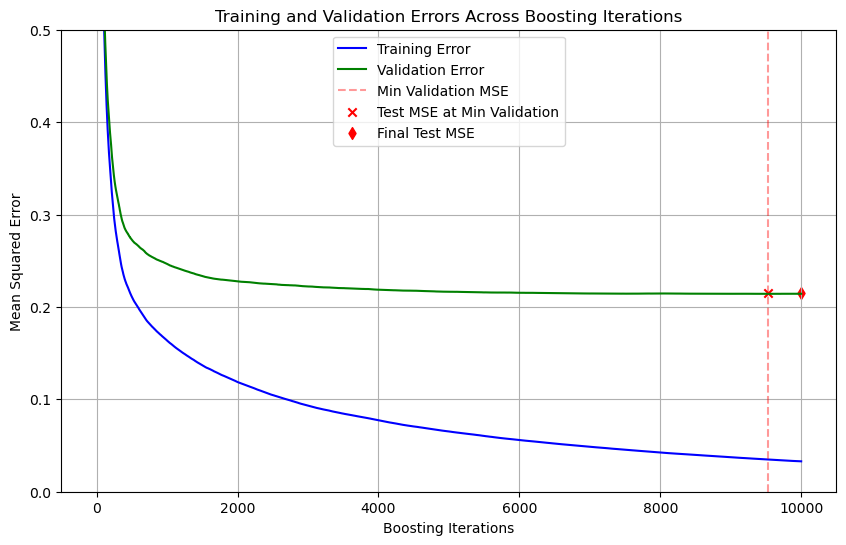

n_estimators: 10000    learning_rate: 0.01    max_depth: 6
Minimum Validation MSE: 0.2101 at iteration 9670
Test MSE at Minimum Validation MSE: 0.2135
Final Test MSE: 0.2136


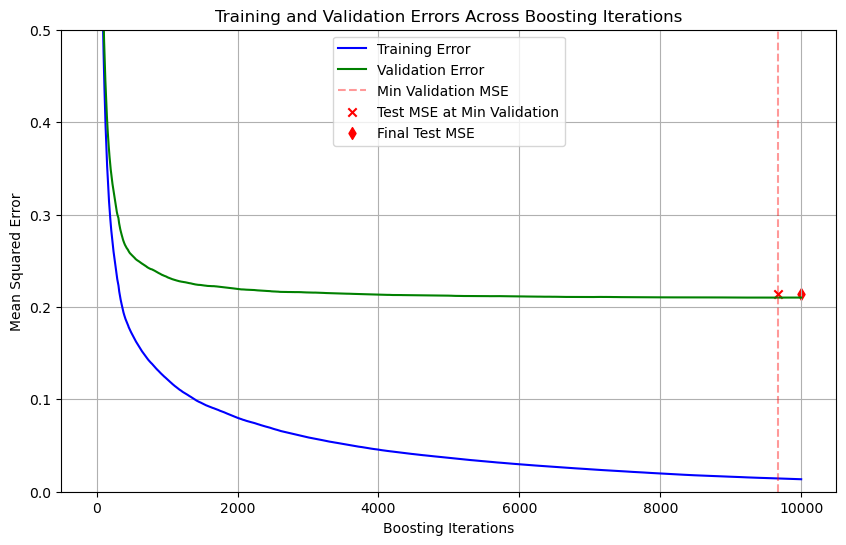

n_estimators: 10000    learning_rate: 0.01    max_depth: 7
Minimum Validation MSE: 0.2127 at iteration 6290
Test MSE at Minimum Validation MSE: 0.2130
Final Test MSE: 0.2127


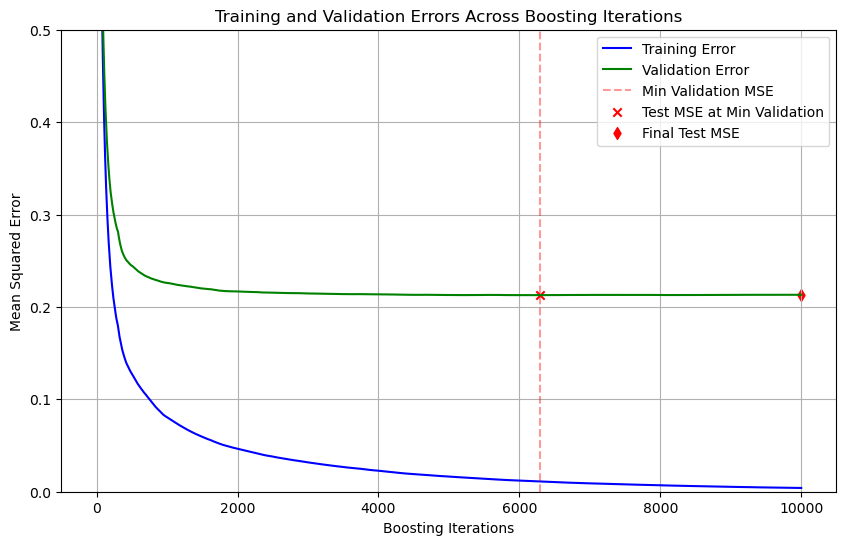

n_estimators: 10000    learning_rate: 0.01    max_depth: 8
Minimum Validation MSE: 0.2160 at iteration 4445
Test MSE at Minimum Validation MSE: 0.2158
Final Test MSE: 0.2155


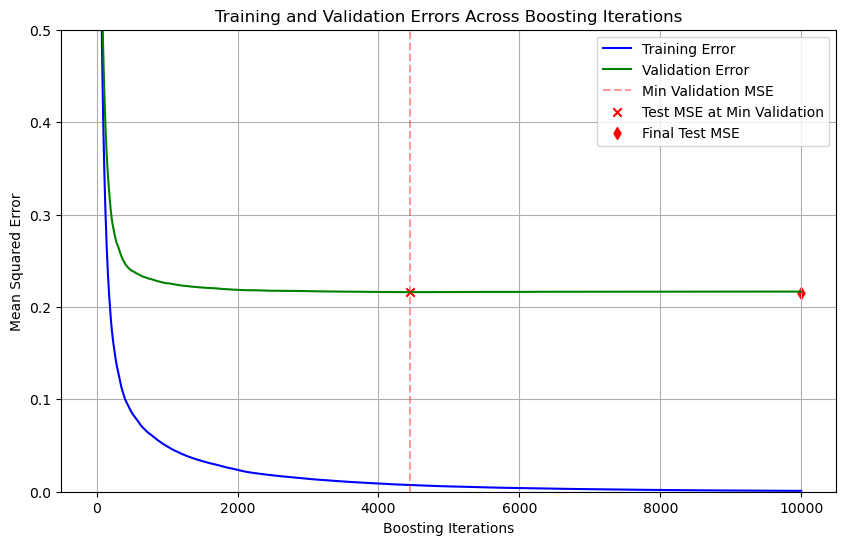

n_estimators: 10000    learning_rate: 0.005    max_depth: 5
Minimum Validation MSE: 0.2169 at iteration 9991
Test MSE at Minimum Validation MSE: 0.2180
Final Test MSE: 0.2180


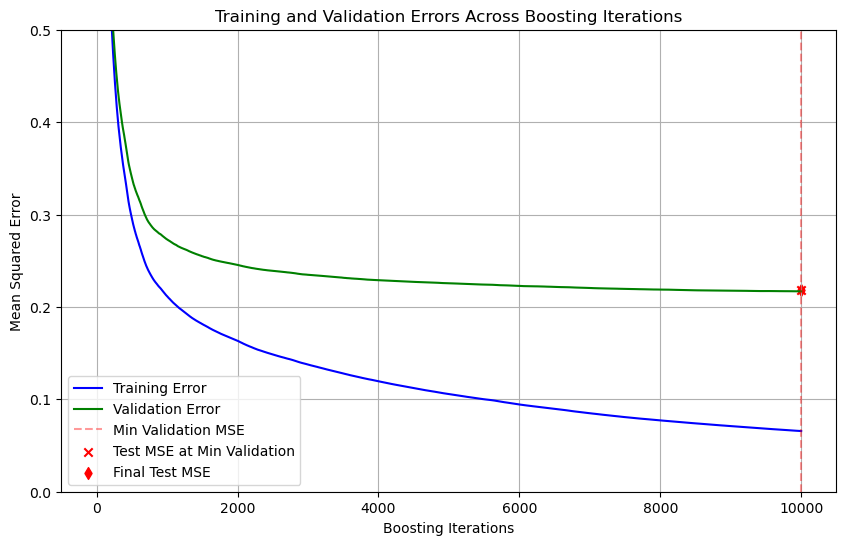

n_estimators: 10000    learning_rate: 0.005    max_depth: 6
Minimum Validation MSE: 0.2109 at iteration 9991
Test MSE at Minimum Validation MSE: 0.2149
Final Test MSE: 0.2149


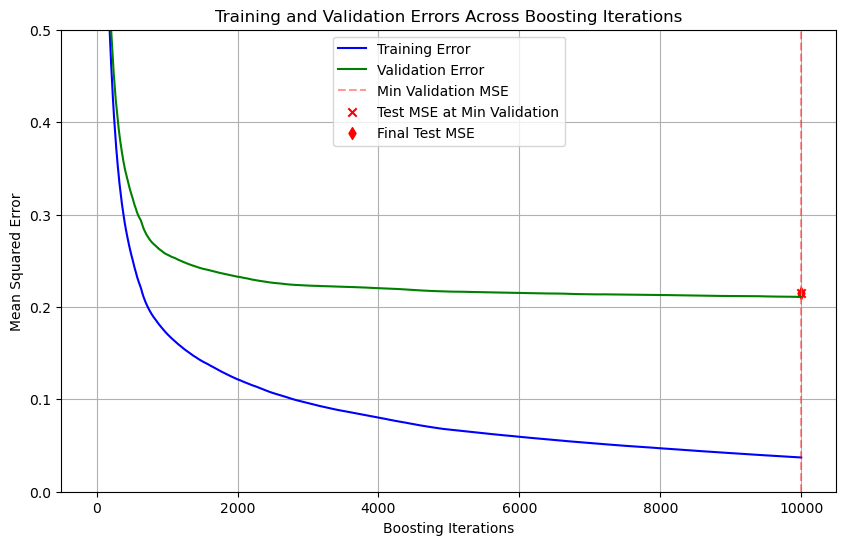

n_estimators: 10000    learning_rate: 0.005    max_depth: 7
Minimum Validation MSE: 0.2095 at iteration 8933
Test MSE at Minimum Validation MSE: 0.2125
Final Test MSE: 0.2125


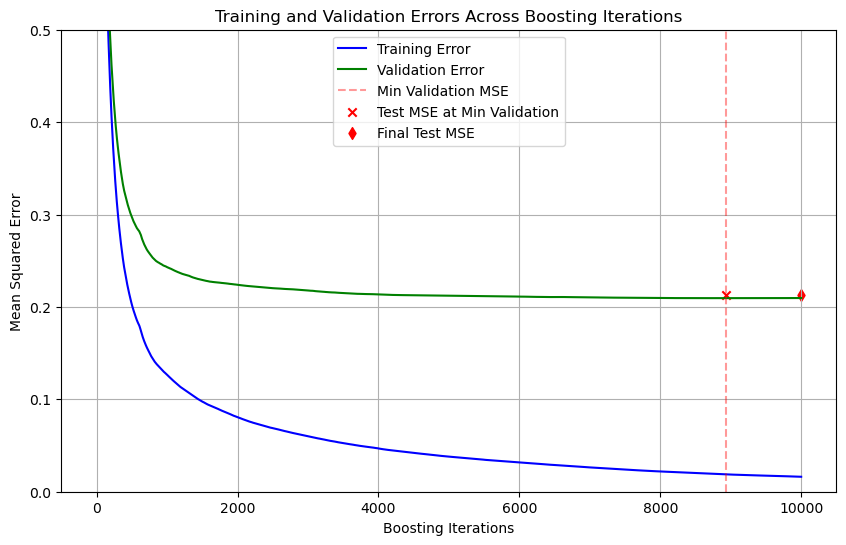

n_estimators: 10000    learning_rate: 0.005    max_depth: 8
Minimum Validation MSE: 0.2135 at iteration 9969
Test MSE at Minimum Validation MSE: 0.2140
Final Test MSE: 0.2140


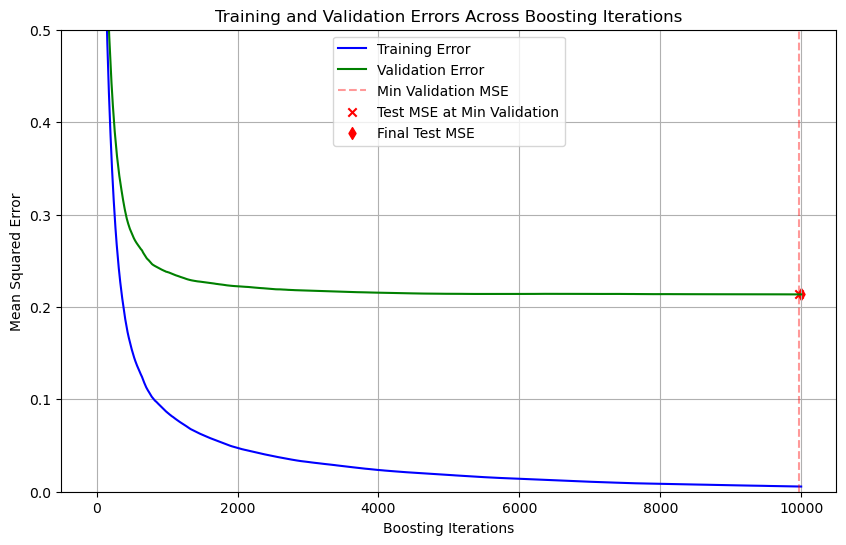

Best three results: [(0.2073789112557529, 4454, 10000, 0.05, 6), (0.2094687971318958, 8933, 10000, 0.005, 7), (0.21006659291397972, 9670, 10000, 0.01, 6)]


In [11]:
run_GB_traces(10000,[0.05, 0.01,0.005],[5,6,7,8])

n_estimators: 20000    learning_rate: 0.005    max_depth: 6
Minimum Validation MSE: 0.2088 at iteration 18284
Test MSE at Minimum Validation MSE: 0.2134
Final Test MSE: 0.2134


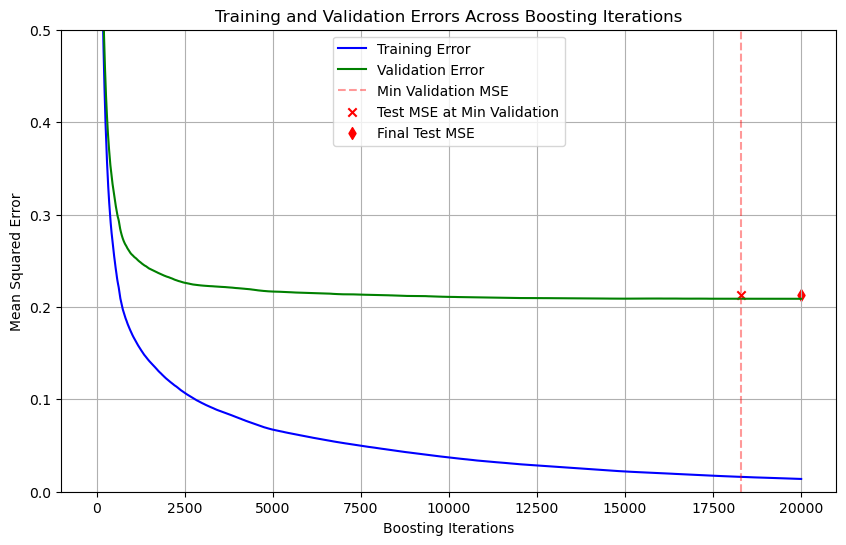

n_estimators: 20000    learning_rate: 0.005    max_depth: 7
Minimum Validation MSE: 0.2092 at iteration 18355
Test MSE at Minimum Validation MSE: 0.2112
Final Test MSE: 0.2112


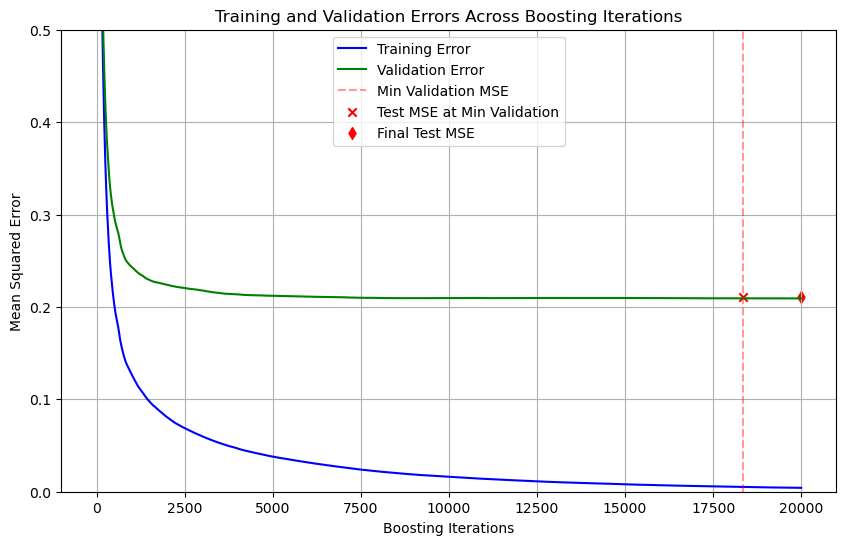

n_estimators: 20000    learning_rate: 0.005    max_depth: 8
Minimum Validation MSE: 0.2124 at iteration 16824
Test MSE at Minimum Validation MSE: 0.2134
Final Test MSE: 0.2135


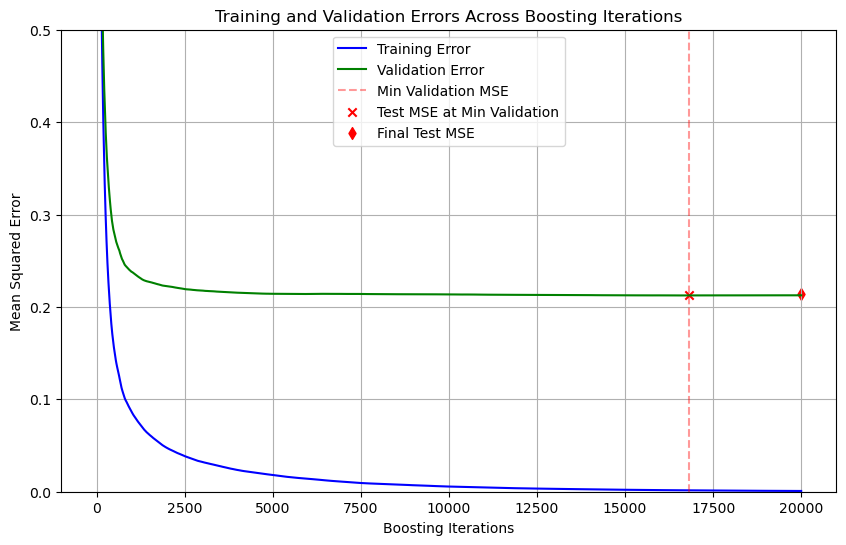

n_estimators: 20000    learning_rate: 0.001    max_depth: 6
Minimum Validation MSE: 0.2197 at iteration 19997
Test MSE at Minimum Validation MSE: 0.2225
Final Test MSE: 0.2225


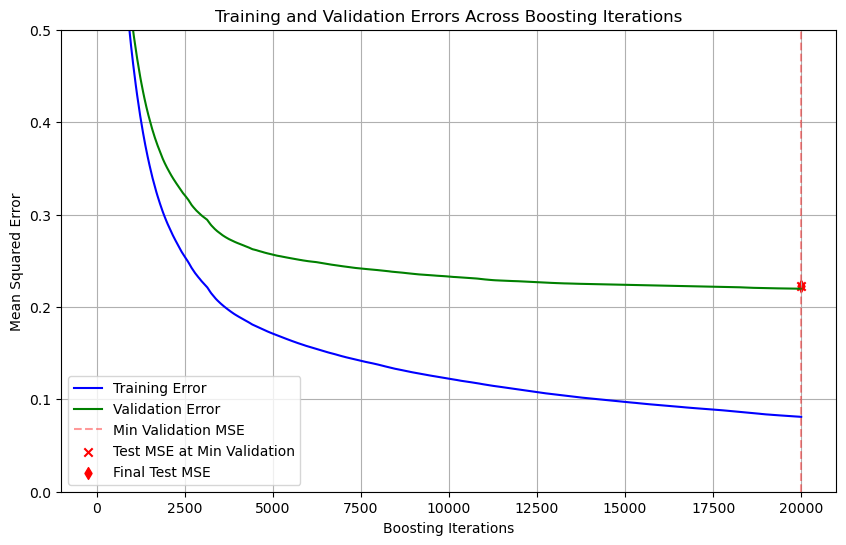

n_estimators: 20000    learning_rate: 0.001    max_depth: 7
Minimum Validation MSE: 0.2159 at iteration 19997
Test MSE at Minimum Validation MSE: 0.2199
Final Test MSE: 0.2199


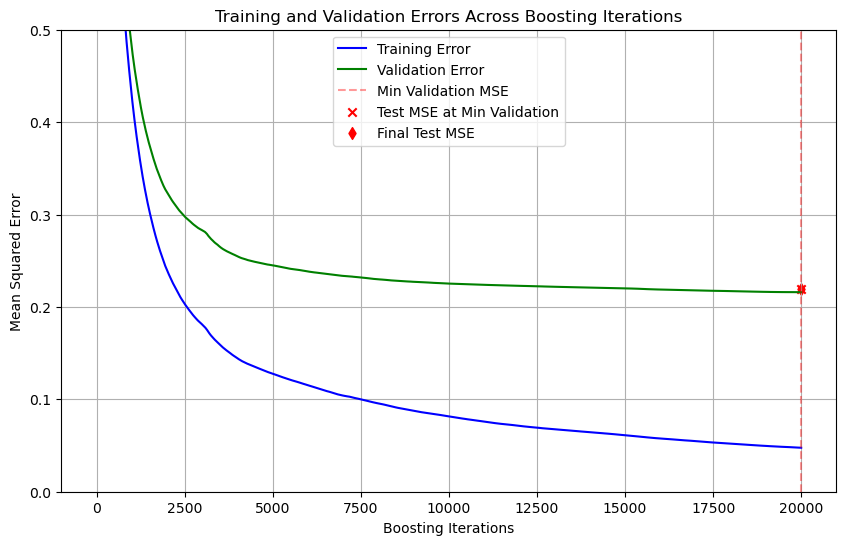

n_estimators: 20000    learning_rate: 0.001    max_depth: 8
Minimum Validation MSE: 0.2169 at iteration 19998
Test MSE at Minimum Validation MSE: 0.2199
Final Test MSE: 0.2199


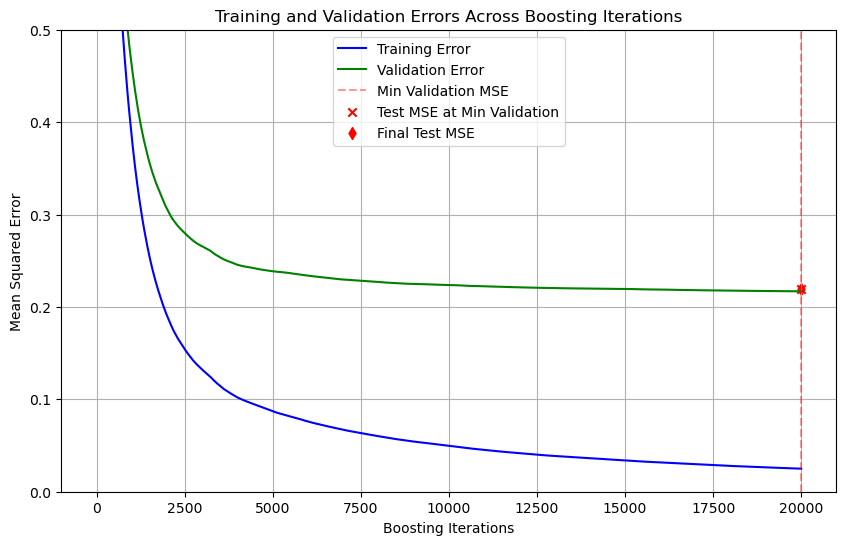

Best three results: [(0.2073789112557529, 4454, 10000, 0.05, 6), (0.20875166735838954, 18284, 20000, 0.005, 6), (0.2092005958377937, 18355, 20000, 0.005, 7)]


In [12]:
run_GB_traces(20000,[0.005,0.001],[6,7,8])

Best three results: 

         (0.20875166735838954, 18284, 20000, 0.005, 6), 
         (0.2092005958377937, 18355, 20000, 0.005, 7), 
         (0.21242279574267298, 16824, 20000, 0.005, 8)

In [13]:
0.2184**0.5

0.4673328578219169

n_estimators: 5000    learning_rate: 0.1    max_depth: 8
Minimum Validation MSE: 0.2184 at iteration 628
Test MSE at Minimum Validation MSE: 0.2192
Final Test MSE: 0.2186


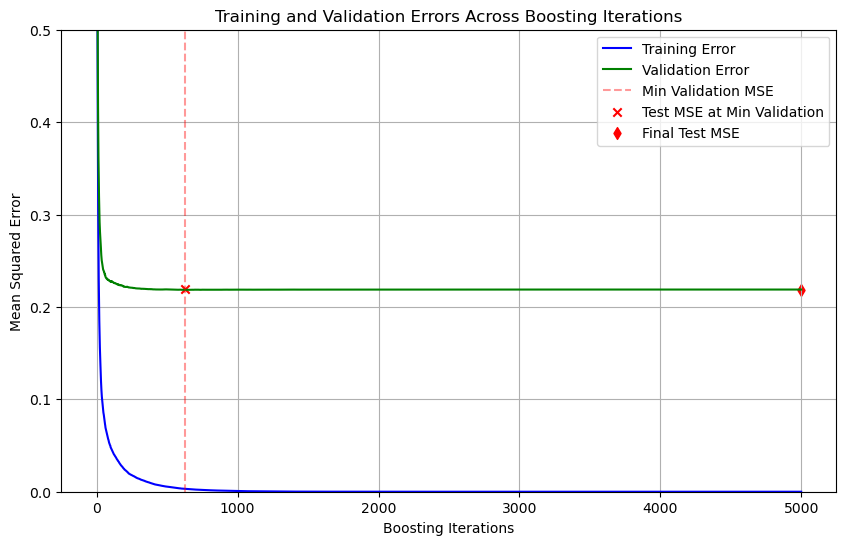

Best three results: [(0.2073789112557529, 4454, 10000, 0.05, 6), (0.20875166735838954, 18284, 20000, 0.005, 6), (0.2092005958377937, 18355, 20000, 0.005, 7)]


In [14]:
run_GB_traces(5000,[0.1],[8])

### Early Stopping

**Early stopping** is a technique to prevent overfitting and reduce computational time in Gradient Boosting by halting the training process when performance on a validation set stops improving. It is especially useful when using a large number of estimators.

In `sklearn`, early stopping can be implemented by using these parameters in `GradientBoostingRegressor` or `GradientBoostingClassifier`:

- **`validation_fraction`**: Proportion of the training data to set aside for validation.
- **`n_iter_no_change`**: Number of boosting iterations with no progress before stopping.
- **`tol`**: Minimum improvement required to consider as progress.

---

### Example Code

(0.20875166735838954, 18284, 20000, 0.005, 6)

In [15]:

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting Regressor with early stopping
gbr = GradientBoostingRegressor(
    n_estimators=20000,       # Max number of boosting iterations
    learning_rate=0.005,
    max_depth=6,
    validation_fraction=0.2,  # Use 20% of training data for validation
    n_iter_no_change=10,      # Stop if no improvement in 10 consecutive iterations
    tol=0e-4,                 # Minimum improvement threshold
    random_state=42
)

# Fit the model
gbr.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred_test = gbr.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)

# Print the results
print(f"Final Test MSE: {test_mse:.4f}")
print(f"Number of Boosting Iterations Run: {gbr.n_estimators_}")


Final Test MSE: 0.2248
Number of Boosting Iterations Run: 2550


In [16]:
Final Validation MSE: 0.2175
Number of Boosting Iterations Run: 166

SyntaxError: invalid syntax (907343890.py, line 1)

n_estimators: 5000    learning_rate: 0.1    max_depth: 8
Minimum Validation MSE: 0.2184 at iteration 628
Test MSE at Minimum Validation MSE: 0.2192
Final Test MSE: 0.2186